# 영화 관객수 예측

## Dataset

* 데이터: https://dacon.io/competitions/open/235536/overview/description
* 필사 출처: https://dacon.io/competitions/open/235536/codeshare/1536?page=1&dtype=vote

* title : 영화의 제목
* distributor : 배급사
* genre : 장르
* release_time : 개봉일
* time : 상영시간(분)
* screening_rat : 상영등급
* director : 감독이름
* dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
* dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
* num_staff : 스텝수
* num_actor : 주연배우수
* box_off_num : 관객수

In [38]:
# 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb

## Data preparation

### Load data

In [5]:
# 압축풀기
# !unzip 영화관객수.sip

In [6]:
# Load the data
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
submission = pd.read_csv("submission.csv")

train.shape, test.shape, submission.shape

((600, 12), (243, 11), (243, 2))

In [13]:
# target 확인
set(train.columns) - set(test.columns)

{'box_off_num'}

## Exploratory Data Analysis (EDA)

In [7]:
# 데이터 확인
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [8]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [31]:
# 수치형변수 기술통계값
pd.options.display.float_format = '{:.1f}'.format
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.0,270.0,600.0,600.0,600.0,600.0
mean,100.9,1050442.9,0.9,151.1,3.7,708181.8
std,18.1,1791408.3,1.2,165.7,2.4,1828005.9
min,45.0,1.0,0.0,0.0,0.0,1.0
25%,89.0,20380.0,0.0,17.0,2.0,1297.2
50%,100.0,478423.6,0.0,82.5,3.0,12591.0
75%,114.0,1286568.6,2.0,264.0,4.0,479886.8
max,180.0,17615314.0,5.0,869.0,25.0,14262766.0


In [32]:
# 장르별 관객수
no_g = train[["genre", "box_off_num"]].groupby("genre").mean().sort_values("box_off_num")
no_g

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


In [15]:
pd.reset_option("display.float_format")

In [17]:
# 상관계수
corr = train.corr()

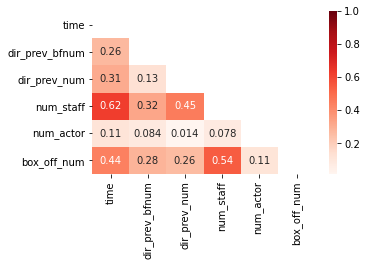

In [29]:
# 상관계수 시각화
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(5,3))
_ = sns.heatmap(corr, cmap="Reds", annot=True, mask=mask)

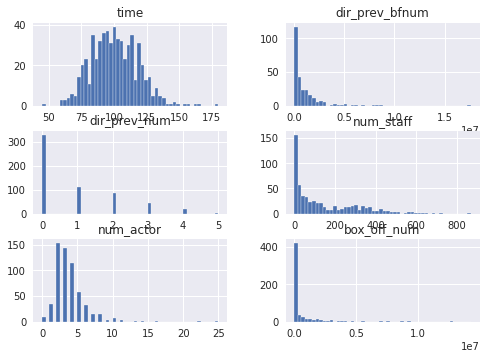

In [41]:
# histogram
_ = train.hist(bins=50)

## Data cleansing & Pre-Processing

In [42]:
# 결측치 확인
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [43]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [44]:
# 결측치 값 0으로 대체
train["dir_prev_bfnum"].fillna(0, inplace=True)

In [45]:
train.isnull().sum().sum()

0

In [46]:
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [47]:
test.isnull().sum().sum()

0

## Feature Engineering & Initial Modeling

In [48]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [49]:
features=['time', 'dir_prev_num', 'num_staff', 'num_actor']
target=["box_off_num"]

In [52]:
X_train, X_test, y_train = train[features], test[features], train[target]

## Model Tuning & Evaluation

### LightGBM

In [53]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [54]:
singleLGBM = submission.copy()

In [55]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [56]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [57]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

### k-fold cross validation

In [58]:
from sklearn.model_selection import KFold

In [59]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=777)

In [60]:
for train_idx, val_idx in k_fold.split(X_train):
    print(len(train_idx), len(val_idx))
    break

480 120


In [61]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.70572e+12
Early stopping, best iteration is:
[6]	valid_0's l2: 2.45438e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.90847e+12
Early stopping, best iteration is:
[33]	valid_0's l2: 3.72825e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.50344e+12
Early stopping, best iteration is:
[8]	valid_0's l2: 2.58737e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.45977e+12
Early stopping, best iteration is:
[11]	valid_0's l2: 1.26226e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.77214e+12
Early stopping, best iteration is:
[22]	valid_0's l2: 1.57631e+12


In [62]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [63]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [64]:
kfoldLightGBM = submission.copy()

In [65]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [66]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3367422.1
1,아빠가 여자를 좋아해,961138.9
2,하모니,1097929.7
3,의형제,2097270.8
4,평행 이론,781476.3


In [67]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index = False)

### feature engineering

In [68]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])

In [69]:
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int64

In [70]:
test['genre'] = le.transform(test['genre'])

In [71]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']

In [72]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [73]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.62067e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.42668e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.39227e+12
Early stopping, best iteration is:
[23]	valid_0's l2: 3.97173e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.29841e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 2.53643e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.56499e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 1.21201e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.60118e+12
Early stopping, best iteration is:
[29]	valid_0's l2: 1.47528e+12


In [74]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum,genre
0,125,2,304,3,300529.0,2
1,113,4,275,3,342700.2,5
2,115,3,419,7,4206610.7,4
3,116,2,408,2,691342.0,10
4,110,1,380,1,31738.0,1


In [75]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [76]:
feLightGBM = submission.copy()

In [77]:
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [78]:
feLightGBM.to_csv('feLightGBM.csv', index = False)

### Grid Search

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)


params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv = k_fold)

In [81]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [82]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [83]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000, learning_rate= 0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.56673e+12
[200]	valid_0's l2: 2.45583e+12
[300]	valid_0's l2: 2.42575e+12
[400]	valid_0's l2: 2.43392e+12
Early stopping, best iteration is:
[335]	valid_0's l2: 2.42348e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.89194e+12
[200]	valid_0's l2: 4.40922e+12
[300]	valid_0's l2: 4.19146e+12
[400]	valid_0's l2: 4.05951e+12
[500]	valid_0's l2: 3.96931e+12
[600]	valid_0's l2: 3.91727e+12
[700]	valid_0's l2: 3.88462e+12
[800]	valid_0's l2: 3.87695e+12
[900]	valid_0's l2: 3.87088e+12
Early stopping, best iteration is:
[876]	valid_0's l2: 3.87035e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.14361e+12
[200]	valid_0's l2: 2.79286e+12
[300]	valid_0's l2: 2.59302e+12
[400]	valid_0's l2: 2.47608e+12
[500]	valid_0's l2: 2.40386e+12
[600]	valid_0's l2: 2.36407e+12
[700]	valid_0's l2: 2.38505e+12
Early stopping, best iteration is:
[647]

In [84]:
preds = []
for model in models:
    preds.append(model.predict(X_test))

In [85]:
gs.best_score_

-2334525343085.6494

In [86]:
gslgbm = submission.copy()

In [87]:
gslgbm['box_off_num'] =  np.mean(preds, axis = 0)

In [88]:
gslgbm.to_csv('gslgbm.csv', index = False)